# Livrable : modélisation et implémentation

# Rappel du contexte
## Description

L’ADEME (Agence de l’Environnement et de la Maîtrise de l’Energie) a récemment lancé un appel à manifestation d’intérêt pour promouvoir la réalisation de démonstrateurs et d’expérimentations de nouvelles solutions de mobilité pour les personnes et les marchandises adaptées à différents types de territoires.

Votre structure CesiCDP est déjà bien implantée dans le domaine. Aidé de nombreux partenaires, vous avez réalisé plusieurs études sur le thème de la Mobilité Multimodale Intelligente. Les nouvelles technologies de transport, plus économiques et moins polluantes ne sont pas sans poser de nouveaux défis notamment d’un point de vue de l’optimisation de la gestion des ressources. Mais ces problèmes de logistique du transport présentent un enjeu majeur pour l’avenir : ses applications sont nombreuses (distribution du courrier, livraison de produits, traitement du réseau routier, ramassage des ordures) et leur impact sur l’environnement peut être véritablement significatif.

Vous faites partie de l’équipe (4 personnes) mise en place par CesiCDP pour répondre à l’appel de l’ADEME. L’enjeu est d’obtenir de nouveaux marchés avec des financements très intéressants pour continuer à développer votre activité.

CesiCDP a décidé d’orienter son étude sur la gestion de tournées de livraison. Le problème algorithmique consiste à calculer sur un réseau routier une tournée permettant de relier entre elles un sous-ensemble de villes, puis de revenir à son point de départ, de manière à minimiser la durée totale de la tournée. Cette optimisation devra tenir compte du trafic prévu sur chaque axe pour les différentes tranches horaires.

L’idée est de proposer une méthode issue de la Recherche Opérationnelle pour générer une tournée de livraison correspondant à ce problème.

Le périmètre reste encore à préciser. Vous avez décrit une version de base du problème. Mais, afin de le rendre plus réaliste et retenir toute l’attention de l’ADEME, vous hésitez à ajouter des contraintes supplémentaires. Il faut s’attendre à ce qu’il soit ainsi plus dur à traiter.


## Contexte


L'ADEME nous demande dans le cadre du devellopement durable de limité l'émission de gaz à effet de serre et de limité la consomation d'énergie.

Le problème algorithmique est de relier entre elle un sous-ensemble de villes, puis de revenir à son point de départ, de manière à minimiser la durée totale de la tournée.

Nous devrons prendre en compte le traffic selon la tranche horaire. 

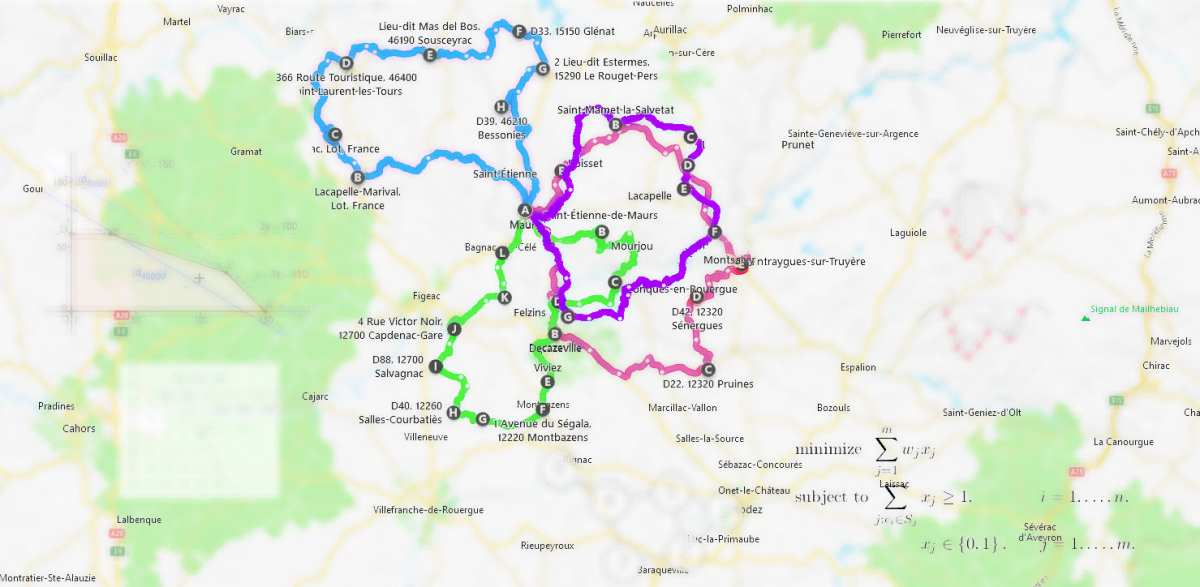

## Besoin

Nous devons optimiser les trajets de transport logistique dans un temps donné.

## Contrainte :

En plus des contraintes imposées par la version de base. Ces dernières étant les suivantes :
- Prendre en compte le trafic routier pour les différentes tranches horaires
- Être scalable et peut prendre en compte plusieurs milliers de villes

Nous avons les contraintes supplémentaires suivantes qui nous sont proposées au choix parmi les quatres suivantes :
- **Fenêtre de temps de livraison pour chaque objet**
- k camions disponibles simultanément pour effectuer les livraisons. Le calcul de la tournée devra inclure l’affectation des objets (et donc des points de livraison) aux différents camions disponibles, et minimiser non plus le temps total, mais la date de retour du dernier camion à la base;
- Chaque objet a un point de collecte spécifique;
- Le temps de parcours d’une arête varie au cours du temps (ce qui revient à faire varier sa longueur), pour représenter la variation du trafic

## Identification du problème :

Notre besoin est, rappelons le, l'optimisation de trajet de transport logistique. Ce problème, si on le ramène à quelque chose de formelle, se rapproche d'un problème de tournées de véhicule (VRP ou *Vehicule Routing Problem*) qui est une extension du TSP (*Travelling Salesman Problem*). Voir Article [Collaboration de solveurs du problème de tournées de
véhicules](https://dial.uclouvain.be/memoire/ucl/en/object/thesis%3A17209/datastream/PDF_01/view) page 15.

![représentationVRP](https://upload.wikimedia.org/wikipedia/commons/2/2b/Figure_illustrating_the_vehicle_routing_problem.png) 

## Problème de tournées de véhicule (VRP)

### Représentation mathématique :

Un problème de tournées de véhicules (VRP) est défini par le modèle mathématique suivant :

$$
\begin{cases}
    & Z=Min \sum_{k = 1}^{p}{\sum_{i = 1}^{n}{\sum_{j = 1}^{n}{d_{ij}x_{ijk}}}} & & (1)\\
    s.c. & \sum_{i = 1}^{n}{x_{ijk}} = \sum_{i = 1}^{n}{x_{jik}} \qquad \forall j \in \{1,...,n\}, \enspace k \in \{1,...,p\} && (2)\\
    & \sum_{k = 1}^{p}{\sum_{i = 1}^{n}{x_{ijk}}} = 1  \qquad \forall j \in \{2,...,n\} && (3)\\
    & \sum_{j = 2}^{n}{x_{1jk}} = 1 \qquad \forall k \in \{1,...,p\} & (4)\\
\end{cases}
$$

* $i, j$ : noeud
* $k$ : véhicule
* $p$ : nombre de véhicules total
* $d_{ij}$ : distance entre deux noeuds
* $n$ : ensemble des noeuds
* $x_{ijk} \in \{0,1\} \qquad \forall k \in \{1,...,p\},\enspace i,j \in \{1,...,n\}$
* $x_{iik} = 0  \qquad \forall k \in \{1,...,p\},\enspace i \in \{1,...,n\}$

Tel que :
- $ (1) $ : Définition de la fonction objectif minimisant le coût/ la distance total(e) de déplacement;
- $ (2)$ : Contraintes assurant que le nombre de fois qu'un véhicule entre dans un nœud est égal au nombre de fois qu'il en sort;
- $ (3) $ : Associée à la première contrainte, elle garantit que chaque nœud n'entre qu'une seule fois et qu'il est quitté par le même véhicule;
- $ (4) $ : Avec la contrainte 1, nous savons que chaque véhicule arrive à nouveau au dépôt;

Nous avons démontrer comment représenter le VRP mathématiquement mais nous pouvons aussi le retrouver avec une contrainte par exemple celle que nous allons utiliser : **Fenêtre de temps de livraison pour chaque noeud**.
Pour cela on peut se référer au VRP que nous avons déjà réalisé et lui appliquer les contrainte ajouté par le *VRPTW* ("Vehicle Routing Problem with Time Window" en français : "Problème de tournées des véhicules avec Fenêtre de temps") : 

$$
\begin{cases}
    s.c. & s_i + t_{ij} - M * (1 - x_{ijk}) \leq s_j \qquad (\forall i \in V, \enspace j \in V \setminus \{1\}, \enspace k \in \{1,...,p\} \qquad && (1)\\
    & \qquad \qquad \qquad \qquad a_i \leq s_i \leq b_i \qquad (\forall i \in V) \qquad \qquad \qquad \qquad \qquad \qquad \qquad && (2)\\
\end{cases}
$$

* $[a_i, b_i]$ : fenêtre de temps du client $ i $
* $s_i$ : heure à laquelle un véhicule commence à servir un client $ i $
* $t_{ij}$ : temps pris du client $ i $ au client $ j $
* $* M = max \{b_i + t_{ij} - a_i\} \qquad i,j \in \{1,...,n\}$ : le plus de temps possible entre $s_i$ et $s_j$

Tel que : 
- $ (1) $ : contrainte permettant de garder la trace de la durée des itinéraires;
- $ (2) $ : contrainte garantissant qu'un véhicule peut commencer à servir un client dans la fenêtre de temps de ce client;

(cf. [Problèmes de tournées de véhicules robustes multi-objectifs](https://www.theses.fr/2018AMIE0030.pdf) et [Capacited Vehicle Routing Problem Formulation](https://how-to.aimms.com/Articles/332/332-Formulation-CVRP.html))

### Etude de la complexité :

Le problème de tournées de véhicule est un problème très difficile à résoudre optimalement. Il faut pour étudier sa complexité passée ce problème sous une forme plus simple.
Nous pouvons considérer dans ce cas, la forme la plus simple du VRP, dans laquelle il n'y a qu'un seul véhicule au service de tous les clients. Cette dernière est équivalente à un *travelling salesman problem*. 

Dans la dynamique d'un algorithme pour le TSP, le nombre de sous-ensembles possible peut être au plus $N \times 2^N$. Chaque sous-ensemble trouve sa solution dans $\mathcal{O}(N)$ fois. De ce fait, la complexité de cet algorithme est $\mathbf{\mathcal{O}(N^{2} \times 2^N)}$.

Où $n$ est le nombre de nœuds à visiter, et $ n! $ est le nombre d'itinéraires différents possibles, le facteur $\frac{1}{2}$ vient du fait que le sens de circulation n'a pas d'importance. [[1]](https://dial.uclouvain.be/memoire/ucl/en/object/thesis%3A17209/datastream/PDF_01/view)



### Classe de problème identifié :

Le problème de tournées des véhicules étant une extension du problème du voyageur de commerce, sa classe de problème est celle des NP-Complet dans le cas où l'on s'intéresse à un problème de décision. Si l'optimisation est prise en compte, alors ce problème va appartenir à la classe des NP-difficile (cf. [Collaboration de solveurs du problème de tournées de véhicules](https://dial.uclouvain.be/memoire/ucl/en/object/thesis%3A17209/datastream/PDF_01/view) page 18, [Résolution des problèmes de tournées de véhicules pour le transport des échantillons biomédicaux au Québec](https://corpus.ulaval.ca/jspui/bitstream/20.500.11794/26365/1/31447.pdf) page 21 et [Problèmes de tournées de véhicules robustes multi-objectifs](https://www.theses.fr/2018AMIE0030.pdf) page 30 )

### Choix de la méthode de résolution :

Il existe plusieurs méthodes pour résoudre le problème des tournées de véhicule. Dans notre cas, il a été décidé d'utiliser une métaheuristique pour permettre d'obtenir de manière approchée une solution optimale. La métaheuristique utilisée est la recherche tabou qui peut être visualisée de cette manière :

![aperçuAlgo](https://www.researchgate.net/profile/Tarek-Bouktir/publication/338659208/figure/fig19/AS:848394666917888@1579284459005/Algorithme-de-recherche-tabou.ppm) 

* $s$ : solution initiale
* $N$ : nombre de voisin
* $t$ : meilleur voisin courant

L'algorithme ci-dessus présente de façon assez basique le fonctionnement de la recherche tabou. L'idée de cette recherche consiste, à partir d'une position donnée, à en explorer le voisinage et à choisir la position dans ce voisinage qui minimise la fonction objectif. C'est à partir de ce mécanisme que l'on sort d'un minimum local pour essayer de trouver une solution plus optimale aileurs.

Cependant, il y a un risque de retomber dans le minimum local auquel on vient d'échapper. C'est pourquoi l'heuristique doit avoir de la mémoire (c-à-d que l'on doit interdire le fait de revenir sur des positions déjà explorés). Pour cela, les positions déjà explorées sont conservées dans une file FIFO (appelée souvent liste tabou) d'une taille donnée ajustable. Elle doit conserver des positions complètes, ce qui dans certains types de problèmes, peut nécessiter l'archivage d'une grande quantité d'informations. Mais il est possible d'éviter ce soucis en ne conservant dans la liste que les mouvements précédents, associés à la valeur de la fonction à minimiser. 

À noter que les perturbations que vont subir la solution initiale seront données par des inversions de valeurs :
* Entre les listes :
    * De manière méthodique en essayant toute les possibilités
    * De manière aléatoire
    * Déplacer un élément dans une autre liste
* Dans les listes :
    * Réarrangement de l'ordre des valeurs entre elles


## Implémentation de l'algorithme et observation : 

Observons avec un cas simple la résolution du problème de tournée de véhicules sans contrainte pour l'instant avec l'utilisation d'une recherche tabou. Ce qui va suivre correspond à l'implémentation de la recherche tabou pour résoudre un VRP simple. Dans notre cas, l'algorithme va se baser sur une matrice des poids déjà précalculée pour obtenir une solution optimale entre 2 nœuds à visiter. À noter que cette matrice pourrait être obtenue grâce à l'utilisation d'une matrice de poids sur un ensemble de points, d'une liste de points à visiter et un algorithme glouton (Dijkstra/Prim).

### L'implémentation de la recherche tabou pour la résolution du VRP dans notre cas est la suivante :

In [1]:
import copy
from itertools import combinations, permutations
import random
from collections import deque
import math
from matplotlib import container
from numpy import Infinity
import matplotlib.pyplot as plt
import time

# Entry parameters
grid_size = 100
nbr_cities = 50
nbr_truck = 10
size_tabu = 20
iter_max = 50

road_pile = [0 for i in range(nbr_truck)]

# Colors for the graph
list_color = {
    1: "red",
    2: "blue",
    3: "green",
    4: "orange",
    5: "c",
    6: "m",
    7: "y",
    8: "purple",
    9: "k",
    10: "lime",
    11: "darkblue",
    12: "lavender",
    13: "blueviolet",
    14: "plum",
    15: "deeppink",
    16: "lightpink",
    17: "teal",
    18: "turquoise",
    19: "tan",
    20: "olive"
}
random.seed(a=3)

In [2]:
def truck_container() -> dict[list[int]]:
    '''
    Generate a list of containers for each truck.

    :return containers: List of containers.
    '''
    containers = {i : [] for i in range(1, nbr_truck+1)}
    return containers

In [3]:
def random_cities() -> dict[list[int]]:
    '''
    Generate a list of random cities.

    :return cities: List of cities.
    '''
    coordinates_cities = {i : [random.randint(-grid_size, grid_size), random.randint(
        -grid_size, grid_size)] for i in range(1, nbr_cities)}
    coordinates_cities_base = {0 : [0, 0]}
    coordinates_cities_base.update(coordinates_cities)
    return coordinates_cities_base

In [4]:
def generate_random_solution(container_truck: dict[list[int]], cities: list[int]) -> dict[list[int]]:
    '''
    Generate a random solution.

    :param container_truck: List of the trucks.
    :param cities: List of the cities.
    :return solution: Solution of the problem.
    '''
    for i in cities : 
        if i != -1:
            container_truck[random.randint(1, nbr_truck)].append(i)
    return container_truck


In [5]:
def distance_between_coord(coord_1: list[int], coord_2: list[int]) -> float:
    '''
    Calculate the distance between 2 coordonnates.

    :param coord_1: Coordinates of the first point.
    :param coord_2: Coordinates of the second point.
    :return distance: Distance between the 2 points.
    '''
    coord_x = (coord_1[0]-coord_2[0])
    coord_y = (coord_1[1]-coord_2[1])
    return math.sqrt(coord_x**2+coord_y**2)


def length_trip(solution: dict[list[int]], num_traject: int) -> float:
    '''
    Calculate the travel distance.

    :param solution: Solution of the problem.
    :param num_traject: Number of the trajectory.
    :return distance: Distance of the trajectory.
    '''
    lenght: float = 0
    last_item: int = 0
    for point in solution[num_traject]:
        lenght += distance_between_coord(coord_city[last_item], coord_city[point])
        last_item = point
    lenght += distance_between_coord(coord_city[last_item], coord_city[0])
    
    return lenght

def length_trip_array(solution: dict[list[int]]) -> float:
    '''
    Calculate the travel distance.

    :param solution: Solution of the problem.
    :param num_traject: Number of the trajectory.
    :return distance: Distance of the trajectory.
    '''
    lenght: float = 0
    last_item: int = 0
    for point in solution:
        lenght += distance_between_coord(coord_city[last_item], coord_city[point])
        last_item = point
    lenght += distance_between_coord(coord_city[last_item], coord_city[0])
    
    return lenght

def total_distance(solution: list[list[int]]) -> float:
    '''
    Calculate the total distance of the solution.

    :param solution: Solution of the problem.
    :return distance: Total distance of the solution.
    '''
    total_lenght = 0
    for i in solution:
        total_lenght += length_trip(solution, i)
    return total_lenght


In [6]:
def test_pos(tableau: list[list[int]], element: int) -> bool:
    '''
    Test if an element is in the tableau.

    :param tableau: Tableau to test.
    :param element: Element to test.
    :return bool: True if the element is in the tableau.
    '''
    table = []
    for i in range(len(tableau)):
        copy_table = tableau.copy()
        copy_table.insert(i, element)
        table.append(copy_table.copy())
    tableau.append(element)
    table.append(tableau.copy())
    return table

#### Fonction de recherche de voisinage

Cette fonction permet de retourner tous les voisins possible d'une solution. Pour se faire :
* la solution courante est récupérée via le paramètre de la fonction.
* une matrice qui prendra les différents dictionnaires représentant nos solutions proches est initialisée à vide

Toutes les valeurs pour chaque camion sont parcourue et une copy de notre solution initiale est réalisée pour mieux la modifier sans modifier la solution initiale.

Dans un premier temps, la valeur x du trajet du camion est retirée pour l'ajouter au trajet d'un autre camion.

Après avoir vérifié à quel camion ce nombre x doit être ajouté, il faut définir à quel emplacement du trajet le situer. Toutes les possibilités sont testées et elles sont ajoutées à notre liste de voisins créés au début quand elles sont plus optimales.

La liste est renvoyée par la fonction une fois tous les voisins proches testés.

In [7]:
def neighbourhood(solution: dict[list[int]]) -> list[list[int]]:
    '''
    Get the list of the neighbours.

    :param solution: List of elements.
    :param p_nbr_truck: truck number
    :return list_neighbours: List of the neighbours.
    '''
    list_neighbours = []
    for camion in solution:
        for i in solution[camion]:
            copy_solution = copy.deepcopy(solution)
            copy_solution[camion].remove(i)
            for combo in test_pos(copy_solution[camion], i):
                copy_solution[camion] = list(combo)
                list_neighbours.append(copy.deepcopy(copy_solution))
            copy_solution[camion].remove(i)
            if camion == nbr_truck:
                
                for combo in test_pos(copy_solution[1].copy(),i):
                    copy_solution[1] = list(combo)
                    list_neighbours.append(copy_solution.copy())
                    
            else:
                
                for combo in test_pos(copy_solution[camion+1].copy(),i):
                    copy_solution[camion+1] = list(combo)
                    list_neighbours.append(copy_solution.copy())

            copy_solution = []            
    return list_neighbours

#### Recherche tabou

La fonction `tabu_search` effectue une recherche tabou : elle prendra en entrée une solution initale à laquelle elle testeras tous les voisins. Si un voisin est meilleur (plus courtes distance) celui-ci deviendra la nouvelle solution courante. Sinon on retournera en arrière et on testera de nouvelle solution parmis celles proposées précedement.

In [8]:
def tabu_search(initial_solution: dict[list[int]], size_tabu: int, iter_max: int) -> list[list[int]]:
    '''
    Calculate the tabou search with max length and interation.

    :param initial_solution: Initial solution of the problem.
    :param size_tabu: Max length of the tabou list.
    :param iter_max: Max iteration of the algorithm.
    :return solution: Solution of the problem.
    '''
    nbr_iter: int = 0
    list_tabu = deque((), maxlen=size_tabu)

    # solution variables for the optimal neighbour search (no tabu)
    current_solution = initial_solution
    best = initial_solution
    best_overrall = initial_solution

    # values variables for the optimal neighbour search (no tabu)
    value_best = total_distance(initial_solution)
    value_best_overrall = value_best

    # analyse statistics de la recherche tabu
    courantes = []
    meilleures_courantes = []

    while (nbr_iter < iter_max):

        # look amoung all neighbours the current solution
        
        for neighbour in neighbourhood(current_solution):
            
            value_neighbour = total_distance(neighbour)

            # update best solution not tabu found

            if value_neighbour < value_best and neighbour not in list_tabu:
                value_best = value_neighbour
                best = neighbour

        # update best solution meet
        if value_best < value_best_overrall:
            best_overrall = best
            value_best_overrall = value_best
            nbr_iter = 0
        else:
            nbr_iter += 1
        meilleures_courantes.append(value_best_overrall)
        courantes.append(value_best)
        # current_solution takes value of best solution not tabfound
        current_solution = best

        # update tabu list
        list_tabu.append(current_solution)

    return best_overrall, courantes , meilleures_courantes

In [9]:
def display_result(p_solution: dict[list[int]]) -> None:
    '''
    Display the solution of the problem.

    :param solution: Solution of the problem.
    '''
    
    plt.title("")

    # plot scatter plot with x and y data
    
    for truck in p_solution:
        x = [0]
        y = [0]
        plt.scatter(x, y)
        print("Camion numéro : " + str(truck))
        print("(0, 0, 0, 0)" + " -> ", end='')
        for item in p_solution[truck]:
            x.append(coord_city[item][0])
            y.append(coord_city[item][1])
            print(str(item) + " -> ", end='')
        print("(0, 0, 0, 0)")
        x.append(0)
        y.append(0)
        plt.plot(x, y, label="camion " + str(truck), marker="o", color=list_color[truck])
        plt.legend()
        
    print(f" Solution actuelle: {p_solution}")
    print(f"Distance total : {total_distance(p_solution)}")
    plt.show()

In [10]:
coord_city = random_cities() 
solution_initiale = generate_random_solution(truck_container(), coord_city)
new_coord_city = {-1 : [Infinity, Infinity]}
coord_city.update(new_coord_city)

Une fois l'implémentation effectuée, il est possible d'afficher un premier résultat avec le passage de la recherche tabou pour évaluer par la suite la performance de l'algorithme.

Camion numéro : 1
(0, 0, 0, 0) -> 48 -> 8 -> 38 -> 14 -> 16 -> 26 -> 46 -> 24 -> 31 -> 22 -> (0, 0, 0, 0)
Camion numéro : 2
(0, 0, 0, 0) -> 0 -> 35 -> 3 -> 12 -> 27 -> 28 -> 13 -> (0, 0, 0, 0)
Camion numéro : 3
(0, 0, 0, 0) -> 15 -> 37 -> 42 -> 5 -> 30 -> 7 -> (0, 0, 0, 0)
Camion numéro : 4
(0, 0, 0, 0) -> 23 -> 32 -> (0, 0, 0, 0)
Camion numéro : 5
(0, 0, 0, 0) -> (0, 0, 0, 0)
Camion numéro : 6
(0, 0, 0, 0) -> 36 -> 39 -> 9 -> 40 -> (0, 0, 0, 0)
Camion numéro : 7
(0, 0, 0, 0) -> 34 -> 10 -> 44 -> 41 -> 17 -> 19 -> 25 -> (0, 0, 0, 0)
Camion numéro : 8
(0, 0, 0, 0) -> 1 -> 47 -> 4 -> 11 -> 33 -> 43 -> 21 -> 6 -> 45 -> 2 -> (0, 0, 0, 0)
Camion numéro : 9
(0, 0, 0, 0) -> (0, 0, 0, 0)
Camion numéro : 10
(0, 0, 0, 0) -> 49 -> 18 -> 29 -> 20 -> (0, 0, 0, 0)
 Solution actuelle: {1: [48, 8, 38, 14, 16, 26, 46, 24, 31, 22], 2: [0, 35, 3, 12, 27, 28, 13], 3: [15, 37, 42, 5, 30, 7], 4: [23, 32], 5: [], 6: [36, 39, 9, 40], 7: [34, 10, 44, 41, 17, 19, 25], 8: [1, 47, 4, 11, 33, 43, 21, 6, 45, 2], 9:

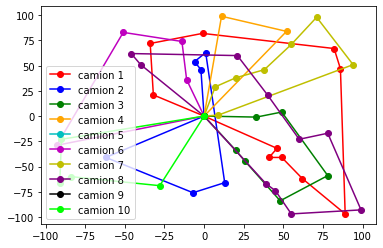

Temps d'exécution : 4.50494384765625 s


In [11]:
start = time.time()
val, courants, meilleurs_courants = tabu_search(solution_initiale, size_tabu, iter_max)
display_result(val)
end = time.time()
elapsed = end - start
print(f'Temps d\'exécution : {elapsed} s')

Puis, on génère un graphe permettant d'évaluer l'évolution de l'optimisation des solutions en fonction du nombre d'itérations de la recherche tabou. Cela permet d'observer la performance de notre algorithme et ainsi d'en déterminer l'instant où l'optimum est atteint ainsi que les possibles limites et pistes d'amélioration.

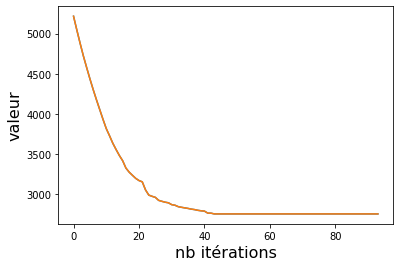

In [12]:
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)
plt.plot(range(len(courants)), courants)
plt.plot(range(len(courants)), meilleurs_courants)
plt.show()

Après avoir généré une solution avec une unique instance de la recherche tabou, il est possible d'affiner encore cette solution en effectuant un multi-start. Il s'agit de lancer successivement la même recherche tabou à partir du même jeu de données avec cependant une solution initiale différente puisque générée aléatoirement à chaque itération.

La solution obtenue ainsi est plus optimale que la solution précédante. En atteste le graphe de solution ci-dessous :

Camion numéro : 1
(0, 0, 0, 0) -> 0 -> 25 -> 46 -> 32 -> 39 -> 47 -> 36 -> (0, 0, 0, 0)
Camion numéro : 2
(0, 0, 0, 0) -> 48 -> 14 -> 2 -> 30 -> 7 -> (0, 0, 0, 0)
Camion numéro : 3
(0, 0, 0, 0) -> 27 -> 49 -> 29 -> (0, 0, 0, 0)
Camion numéro : 4
(0, 0, 0, 0) -> 8 -> 16 -> 21 -> 43 -> 26 -> 19 -> 41 -> 44 -> 10 -> 34 -> (0, 0, 0, 0)
Camion numéro : 5
(0, 0, 0, 0) -> 20 -> 1 -> 24 -> 12 -> 35 -> 11 -> (0, 0, 0, 0)
Camion numéro : 6
(0, 0, 0, 0) -> (0, 0, 0, 0)
Camion numéro : 7
(0, 0, 0, 0) -> 3 -> 31 -> 9 -> 17 -> 23 -> 4 -> (0, 0, 0, 0)
Camion numéro : 8
(0, 0, 0, 0) -> 22 -> 40 -> 18 -> 13 -> 28 -> 45 -> 5 -> 6 -> 42 -> 38 -> 33 -> 37 -> 15 -> (0, 0, 0, 0)
Camion numéro : 9
(0, 0, 0, 0) -> (0, 0, 0, 0)
Camion numéro : 10
(0, 0, 0, 0) -> (0, 0, 0, 0)
 Solution actuelle: {1: [0, 25, 46, 32, 39, 47, 36], 2: [48, 14, 2, 30, 7], 3: [27, 49, 29], 4: [8, 16, 21, 43, 26, 19, 41, 44, 10, 34], 5: [20, 1, 24, 12, 35, 11], 6: [], 7: [3, 31, 9, 17, 23, 4], 8: [22, 40, 18, 13, 28, 45, 5, 6, 42, 38,

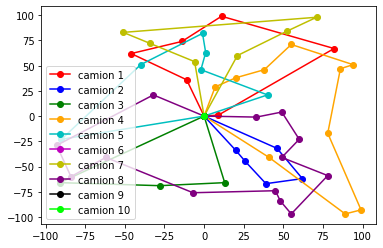

Temps d'exécution : 181.7007122039795 s


In [13]:
start = time.time()
random.seed(a=5)
nb_starts = 50
val_max: list[list[int]] = {1 : [-1]}
# Multi-start
for iter in range(nb_starts):
    solution_initiale = generate_random_solution(truck_container(), coord_city)
    val, courants, meilleurs_courants = tabu_search(solution_initiale, size_tabu, iter_max)
    if total_distance(val) < total_distance(val_max):
        val_max = val
display_result(val_max)
end = time.time()
elapsed = end - start
print(f'Temps d\'exécution : {elapsed} s')

# Observations et interprétation de l'algorithme
## Observations des performances de la solution
La solution obtenue est bien meilleure que la solution initiale. Cela correspond d'ailleurs aux prédictions de la courbe d'évolution qui montre que l'on atteint un optimum en un certain nombre d'itérations. En fonction du jeu de données, les résultats changeront mais le constat restera le même :

### Test effectué avec :
* Camion : 5, Villes : 25, iterations : 100, tabou : 20, grid : 100x100 
#### Distance obtenue avant multi-start : 803.373
![PremierTest](https://cdn.discordapp.com/attachments/991604273022500914/991604875186159686/unknown.png)
![PremierTest2](https://cdn.discordapp.com/attachments/991604273022500914/991605012419588137/unknown.png)
#### Distance obtenue après multi-start : 508.228
![PremierTest3](https://cdn.discordapp.com/attachments/991604273022500914/991607840630378566/unknown.png)


### Test effectué avec :
* Camion : 10, Villes : 50, itérations : 100, tabou : 20, grid : 2000x2000 
#### Distance obtenue avant multi-start : 27635.521
![DeuxièmeTest](https://cdn.discordapp.com/attachments/991604273022500914/991608383725641728/unknown.png)
![DeuxièmeTest2](https://cdn.discordapp.com/attachments/991604273022500914/991608767974232064/unknown.png)
#### Distance obtenue après multi-start : 25792.481
![DeuxièmeTest3](https://cdn.discordapp.com/attachments/991604273022500914/991611338621194302/unknown.png)



Plus les itérations sont importantes, plus la solution est stable. Cependant, même en augmentant le nombre d'itération, à partir d'un certain seuil, la solution optimale se stabilisé et cesse de se minimiser. Ici, ce effet est observé en 30 pour le deuxième test. Ce lemme reste vrai quelque soit les valeurs d'entrées de la solution initiale (client, camion, ...).

Cette limitation est due à la complexité de la recherche tabou. En effet, la recherche tabou est une méthode qui ne permet pas de trouver la solution exacte mais de trouver une solution optimale dans un certain nombre d'itérations.

On cherche cependant à s'approcher de la solution exacte. Pour ce faire, il est possible de :
* **Choisir une solution initiale** facilement optimisable (Dijkstra/Prim)
* **Intensifier** les recherche dans les voisinages de solutions qui semble propices à mener à des solutions proches ou égales à l'optimum
* **Diversifier** la recherche en éloignant celle-ci de voisinages peu propice à produire de bonne solutions
* Mettre en place du **multi-thread** sur le multi-start pour ainsi maximiser l'utilisation du processeur et accélérer et paralélliser le traitement des multiples recherches tabou.
* En fonction de l'instance étudiée, utiliser un algorithme plus adapté à la résolution (colonies de fourmis, algorithme génétique, etc.)

cf. [**Recherche Tabou** - Joseph Ayas & Marc André Viau - 16 novembre, 2004](http://www2.ift.ulaval.ca/~dupuis/Optimisation%20lineaire%20et%20applications/Divers%20Optimisation/Recherche_Tabou.pdf)

# Bibliographie

- Wikipedia contributors. (2021, 19 juillet). Problème de tournées de véhicules. Wikipedia. https://fr.wikipedia.org/wiki/Probl%C3%A8me_de_tourn%C3%A9es_de_v%C3%A9hicules
- Technologie, S. N. E. (s. d.). Calcul d’itinéraires. isn-icn-ljm. https://isn-icn-ljm.pagesperso-orange.fr/Cartographie/co/activiteapprentissage_itineraire_1.html?mode=html
- C. (s.d.). Complexité d’un algorithme – l'Informatique, c'est fantastique ! Récupéré sur Page de cours d'informatique pour le Lycée Blaise Pascal de Clermont Ferrand: https://info.blaisepascal.fr/nsi-complexite-dun-algorithme
- ESSADDOUKI, M. (2017, 09 26). Complexité asymptotique - notations. Récupéré sur Developpement Informatique: https://developpement-informatique.com/article/105/complexite-asymptotique---notations
- Frigot, É. (2022, 03 30). Le voyageur de commerce. Récupéré sur DataVis: https://www.datavis.fr/playing/salesman-problem
- Guerraoui, R. (s.d.). P versus NP : exemple dans un réseau social. Récupéré sur YouTube: https://www.youtube.com/watch?v=rkDlTQFucBM
- Laforest, C. (2017). À la découverte des graphes et des algorithmes de graphes. EDP Sciences. Récupéré sur ScholarVox Université.
- Louapre, D. (2020, 07 17). Est-ce que P = NP ? – Science étonnante. Récupéré sur Science étonnante: https://scienceetonnante.com/2020/07/17/est-ce-que-p-np/
- Badoux, L. (2018). Collaboration de solveurs du problème de tournées de véhicules. Louvain. https://dial.uclouvain.be/memoire/ucl/en/object/thesis%3A17209/datastream/PDF_01/view
- Wikipédia contributors. (2022, 05 31). Problème du voyageur de commerce. Retrieved from Wikipédia: https://fr.wikipedia.org/wiki/Problème_du_voyageur_de_commerce
- BEDERINA, H. (2018). Problèmes de tournées de véhicules robustes multi-objectifs. Amiens: Université de Picardie. https://www.theses.fr/2018AMIE0030.pdf
- Chabot, T. (2015). Résolution des problèmes de tournées de véhicules pour le transport des échantillons biomédicaux au Québec. Québec: Université Laval. https://corpus.ulaval.ca/jspui/bitstream/20.500.11794/26365/1/31447.pdf 
- Brian Kallehauge, J. L. (n.d.). Vehicle Routing Problem with Time Windows. http://alvarestech.com/temp/vrptw/Vehicle%20Routing%20Problem%20with%20Time%20Windows.pdf
- Sandra Ulrich NGUEVEU, S. U. N. (s. d.). Optimisation et Sûreté des Systèmes Année 2009. homepages.lass.fr. https://homepages.laas.fr/sungueve/Docs/PhD/These_SUNGUEVEU_20062009.pdf
- Recherche Tabou - Joseph Ayas & Marc André Viau - 16 novembre, 2004 http://www2.ift.ulaval.ca/~dupuis/Optimisation%20lineaire%20et%20applications/Divers%20Optimisation/Recherche_Tabou.pdf